#  Прогнозирование заказов такси

В данной работе необходимо построить модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. В распоряжении исторические данные компании «Такси» о заказах такси в аэропортах.

#### Задачи: 
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import random
import warnings
warnings.filterwarnings('ignore')

Импортируем данные

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
#data = pd.read_csv('/Users/Mikalai/Documents/Data Science/Временные ряды/taxi.csv', parse_dates=[0])   

Познакомимся с данными

In [3]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Информация о данных

In [4]:
data.shape

(26496, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверим данные на пропуски

In [7]:
data.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проверим данные на дубликаты в столбце datetime. Не должно быть двух и более записей на одну и ту же дату

In [9]:
data['datetime'].unique()

array(['2018-03-01T00:00:00.000000000', '2018-03-01T00:10:00.000000000',
       '2018-03-01T00:20:00.000000000', ...,
       '2018-08-31T23:30:00.000000000', '2018-08-31T23:40:00.000000000',
       '2018-08-31T23:50:00.000000000'], dtype='datetime64[ns]')

Удалим дубликаты в столбце datetime, если такие есть

In [10]:
data.drop_duplicates(subset='datetime', inplace=True)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Количество строк осталось прежним. Записей на одну и ту же дату не было

Установим индекс таблицы равным столбцу datetime

In [12]:
data=data.set_index('datetime')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [14]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проверим расположены ли даты по порядку

In [15]:
print(data.index.is_monotonic)

True


Данные загружены.

В таблице 26496 строк

В таблице два признака:
- дата/время. Этот признак сделали индексом
- количество заказов

В таблице находятся  данные за период с 2018-03-01 00:00:00 пo 2018-08-31 23:50:00 с разбивкой по 10 мин.
Даты раположены по порядку и без пропусков и дубликатов

Так как необходимо спрогнозировать количество заказов такси на следующий час, проведем ресемплирование по одному часу и по каждому часу просуммируем количество заказов

In [16]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [17]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


##### Вывод

Данные без пропусков и аномальных значений.
Выполнили ресемплирование данных по одному часу и по каждому часу просуммировали количество заказов

## 2. Анализ

Посмотрим на графике распределение заказов на протяжении всего временного ряда перед декомпозицией. Чтобы во временном ряду снизить колебания, применим скользящее среднее 

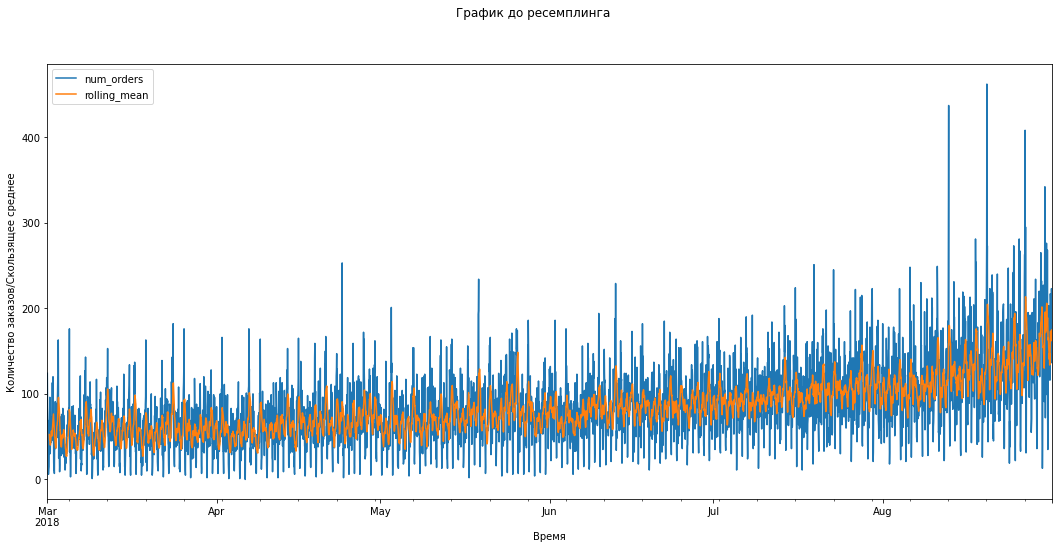

In [18]:
data.resample('1D').sum()
data['rolling_mean'] = data.rolling(10).mean()
data.plot(figsize = (18, 8))
plt.suptitle('График до ресемплинга')
plt.xlabel('Время')
plt.ylabel('Количество заказов/Cкользящее среднее')
plt.show()

Можем сделать вывод, что временной ряд меняется. Количество заказов такси в аэропортах растет во времени. Наиболее активный рост наблюдается в летние месяцы. Это связано с периодом отпусков

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики за весь период временного ряда и за месяц. Проанализируем данные

In [19]:
data = data.drop(['rolling_mean'], axis=1)

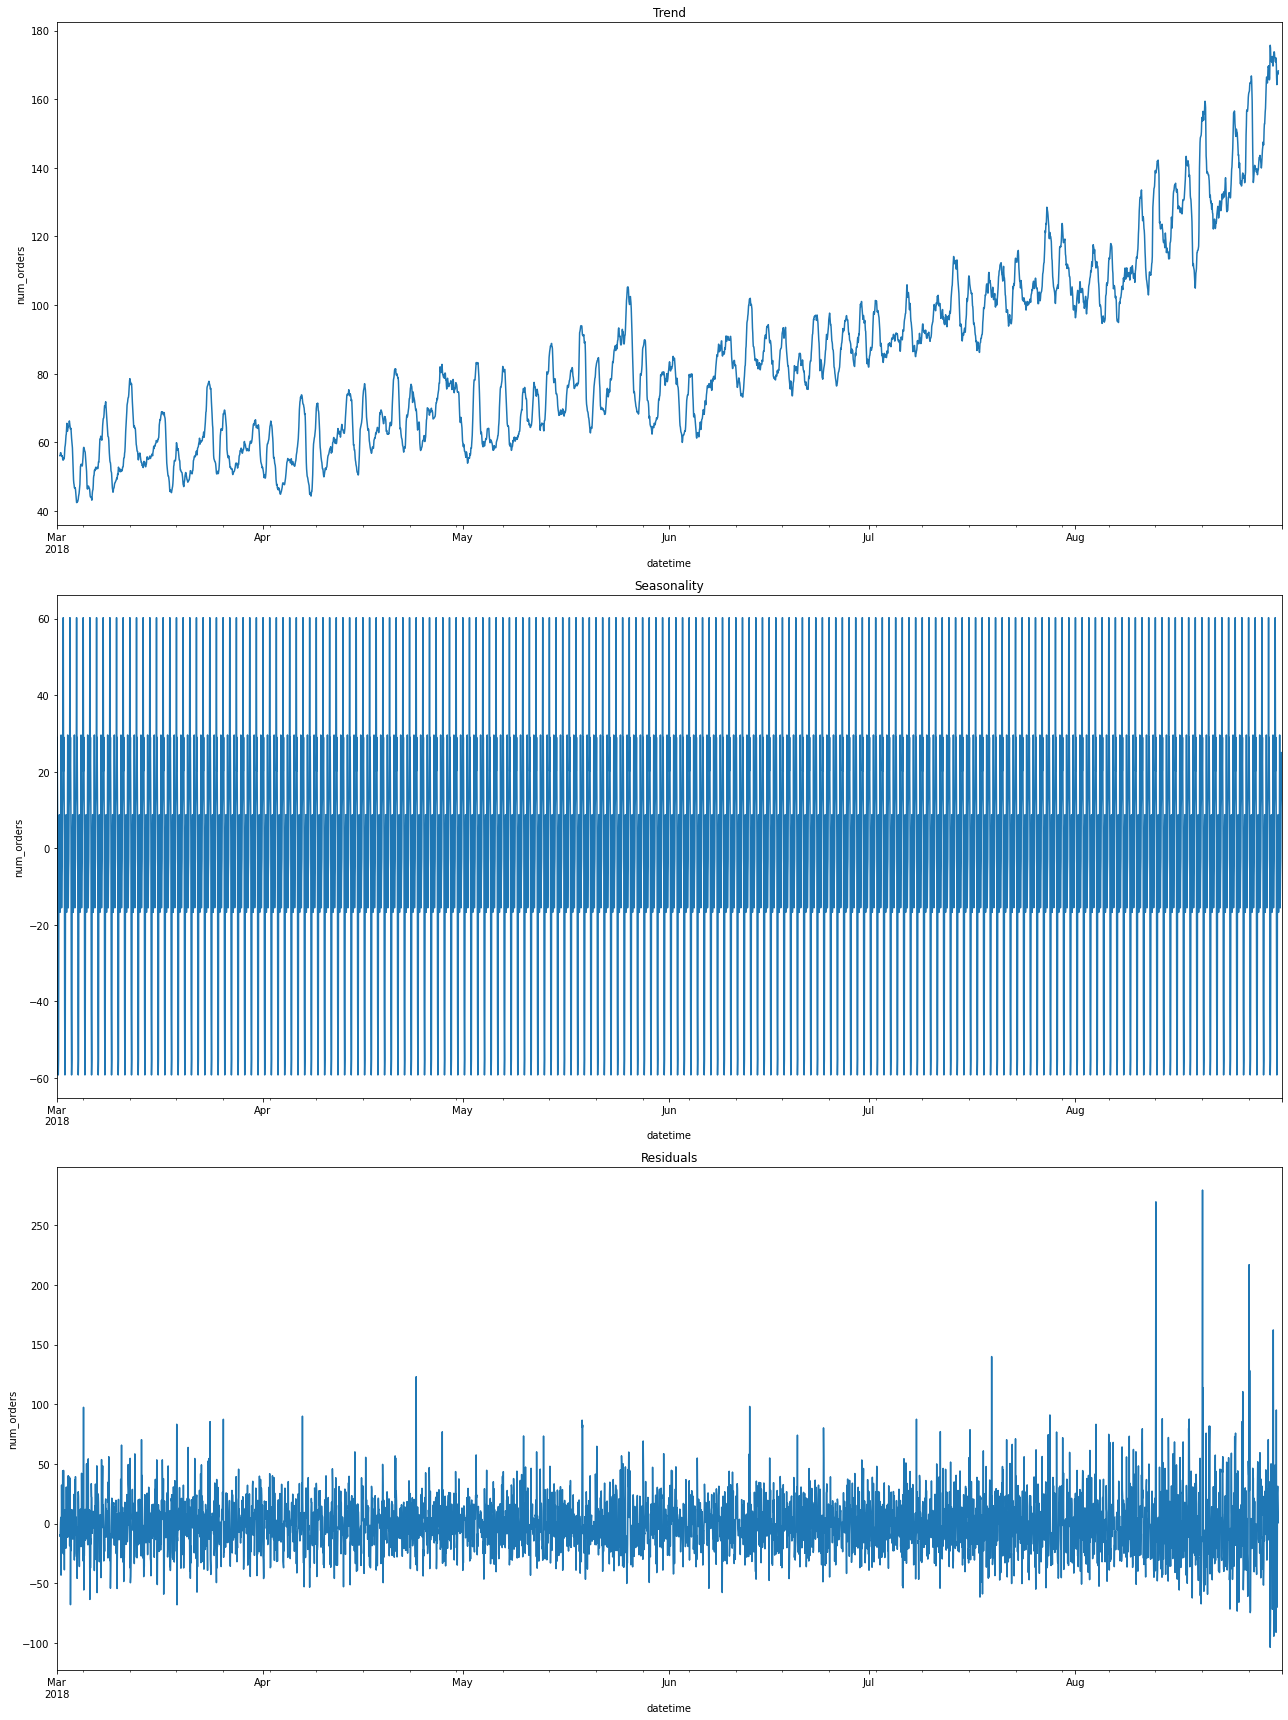

In [20]:
decomposed = seasonal_decompose(data['2018-03':'2018-08'])
plt.figure(figsize=(18, 24))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('num_orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('num_orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('num_orders')
plt.tight_layout()

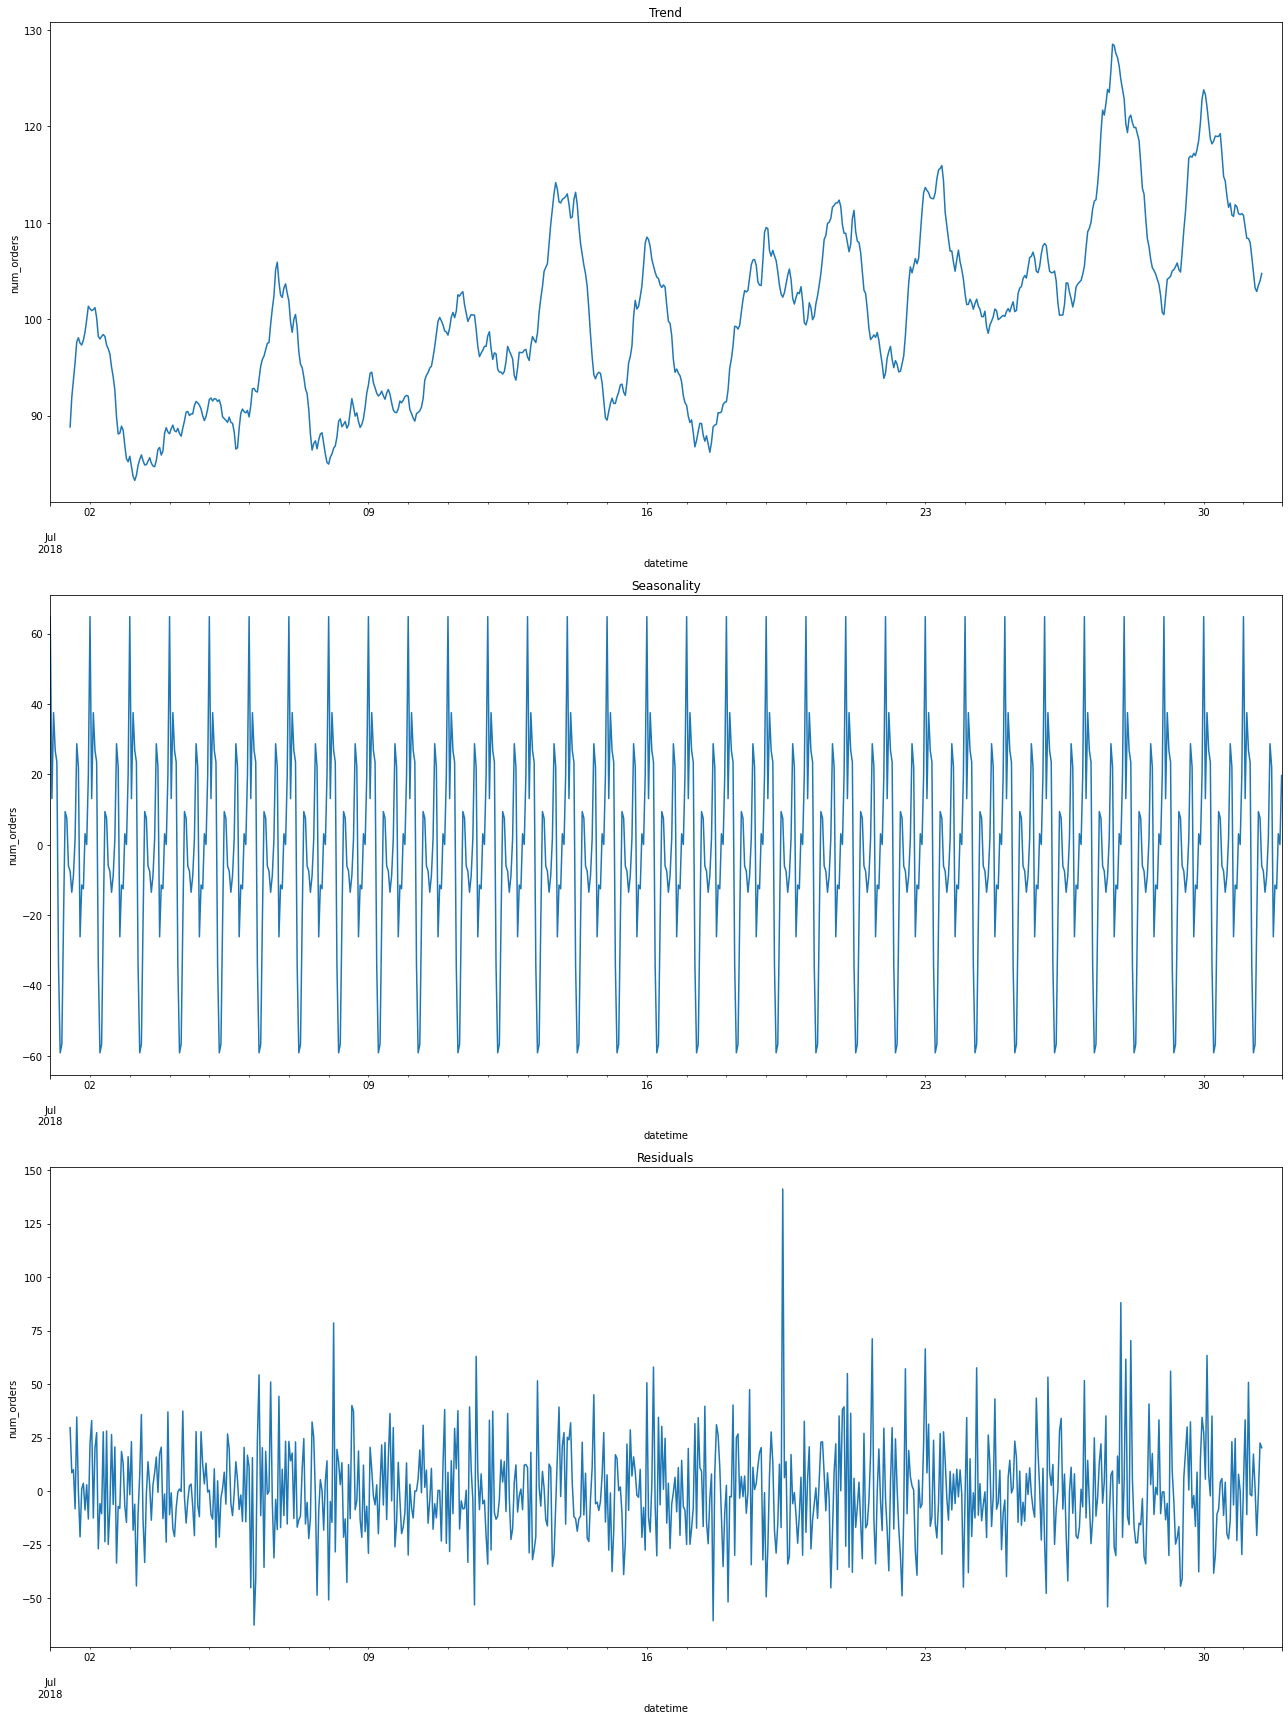

In [21]:
decomposed = seasonal_decompose(data['2018-07':'2018-07'])
plt.figure(figsize=(18, 24))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('num_orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('num_orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('num_orders')
plt.tight_layout()

Трэнд имеет имеет растущую во времени зависимость. Какая это зависимость оценить сложно. Так как необходимо спрогнозировать количество заказов такси только на один следующий час, то будем считать, что тренд линейный. На тренде виден более активный рост заказов такси в летние месяцы, что связано с периодом отпусков.  

Распределение сезонной части выглядит статическим в интервале суток. Минимум заказов такси приходится на раннее утро, максимальный пик - в районе полуночи. Это свзано с тем, поздним вечером ближе к полуночи общественный транспорт ходит реже, и пасажиры выбирают чаще такси, чтобы добраться в аэропорт или с аэропорта. Минимум приходится на раннее утро, потому что на это время приходится минимум рейсов. 

Случайная часть имеет постоянное среднее значение около нуля. Вместе с тем случайная часть ряда показывает сильные выбросы время от времени. Исходя из этого, можно сделать предположение о нестационарности временного ряда. Периодически возникающие всплески можно объяснить повышенным спросом на такси в определенный праздничный или выходной день.

Для подтверждения предположения о нестационарности временного ряда  воспользуемся тестом Дики — Фуллера

In [22]:
result = adfuller(data['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза отвергнута – Временной ряд стационарен
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен


Результат теста Дики — Фуллера с уровнем значимости 1% подтверждает предположение о нестационарности нашего временного ряда

## 3. Обучение

Для обучения и предсказания выберем следующие модели:
- LinearRegression
- RandomForestRegressor
- XGBoostRegressor
- LGBMRegressor

Для оценки качества предсказания моделей будем применять метрику RMSE

Сначала выполним подготовку признаков. Напишем функцию для создания обучающих признаков.

Добавим дополнительные признаки day, dayofweek, hour, а также  признаки отстающего значения lag_i и скользящего среднего rolling_mean с размером окна rolling_mean_size

In [23]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Выберем признак отстающего значения lag_i от 1 до 10

Выберем признак скользящего среднего rolling_mean с размером окна 10

In [24]:
data = make_features(data, 10, 10)

In [25]:
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим выборку на тестовую и обучающую с параметром shuffle=False. Удалим из обучающей выборки строки с пропусками

In [26]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train.shape, test.shape

((3964, 15), (442, 15))

Выделим признаки и целевой признак

In [27]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((3964, 14), (442, 14), (3964,), (442,))

Отмасштабируем количественные признаки для обучения линейной модели 

In [28]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scal = scaler.fit_transform(features_train)
features_test_scal = scaler.transform(features_test)

Перед обучением моделей используем специальный инструмент библиотеки sklearn для кросс-валидации временных рядов TimeSeriesSplit, который не перемешивает объекты обучения при делении на фолды. 

Инициируем экземпляр валидатора с 3 фолдами

In [29]:
TSCV = TimeSeriesSplit(3)

#### 3.1 Обучение модели LinearRegression

Обучим модель LinearRegression с базовым набор гиперпараметров

In [ ]:
%%time
print('Расчеты на модели LinearRegression')
model_Linear = LinearRegression()
model_Linear.fit(features_train_scal, target_train)

Метрика RSME на модели LinearRegression

In [31]:
mse = cross_val_score(model_Linear, features_train_scal, target_train, cv=TSCV, scoring='neg_root_mean_squared_error')
f"RMSE на модели LinearRegression: {round(-mse.mean(), 2)}"

'RMSE на модели LinearRegression: 33.75'

#### 3.2 Обучение модели DecisionTreeRegressor

Подберем гиперпараметры для модели DecisionTreeRegressor

In [32]:
%%time
clf = DecisionTreeRegressor(random_state = 12345)

parameter_grid = {
    'max_depth': [None] + list(np.arange(2,7,1).astype(int)),
    'max_features': ['auto', 'sqrt', None],
    'min_samples_split': [2, 5, 10]
}

grid_searcher_tree = RandomizedSearchCV(clf, parameter_grid, scoring='neg_root_mean_squared_error', cv=TSCV, verbose= True, n_jobs = -1)

grid_searcher_tree.fit(features_train, target_train)

print('Лучшие параметры DecisionTreeRegressor:', grid_searcher_tree.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры DecisionTreeRegressor: DecisionTreeRegressor(max_depth=6, random_state=12345)
Wall time: 5.47 s


Метрика RSME на модели DecisionTreeRegressor

In [33]:
f"RMSE на модели DecisionTreeRegressor: {round(-grid_searcher_tree.best_score_, 2)}"

'RMSE на модели DecisionTreeRegressor: 33.35'

#### 3.3 Обучение модели XGBoostRegressor

Подберем гиперпараметры для модели XGBoostRegressor

In [34]:
%%time
clf = XGBRegressor(n_jobs= -1, random_state=12345)

parameter_grid = {'max_depth': [1, 5, 6, 7],
              'n_estimators': [500] 
              }

grid_searcher_XGBoost = RandomizedSearchCV(clf, parameter_grid, scoring='neg_root_mean_squared_error', verbose=10, cv=TSCV, n_jobs= -1)

grid_searcher_XGBoost.fit(features_train, target_train)
 
print('Лучшие параметры XGBRegressor:', grid_searcher_XGBoost.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры XGBRegressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500,
             n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=12345, reg_alpha=0, reg_lambda=1, ...)
Wall time: 6.64 s


Метрика RSME на модели XGBoostRegressor

In [35]:
f"RMSE на модели XGBoostRegressor: {round(-grid_searcher_XGBoost.best_score_, 2)}"

'RMSE на модели XGBoostRegressor: 28.47'

##### 3.4 Обучение модели LGBMRegressor

Подберем гиперпараметры для модели LGBMRegressor

In [36]:
%%time
clf = LGBMRegressor(random_state = 12345) 
     
parameter_grid = {
            'num_leaves': [32, 64],
            'max_depth': [-1, 10, 50],
            'n_estimators': [1000, 3000],
            'learning_rate' : [0.1, 0.01]
                  }
                  
grid_searcher_LGMB = RandomizedSearchCV(clf, parameter_grid, scoring='neg_root_mean_squared_error', verbose=10, cv=TSCV, n_jobs=-1)
 
grid_searcher_LGMB.fit(features_train, target_train)                    
                    
print('Лучшие параметры LGBMRegressor:', grid_searcher_LGMB.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры LGBMRegressor: LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=32,
              random_state=12345)
Wall time: 46.4 s


Метрика RSME на модели LGBMRegressor

In [37]:
f"RMSE на модели LGBMRegressor: {round(-grid_searcher_LGMB.best_score_, 2)}"

'RMSE на модели LGBMRegressor: 27.73'

Проанализируем все модели на качество предсказания

Линейная регрессия LinearRegression:
- RMSE - 33.75

Модель решающее дерево для регрессии DecisionTreeRegressor:
- RMSE - 33.35

Модель градиентного бустинга XGBoostRegressor:
- RMSE - 28.47

Модель градиентного бустинга LGBMRegressor:
- RMSE - 27.73

Сведем все данные в таблицу 

In [39]:
results = {'Модель':['LinearRegression','DecisionTreeRegressor','XGBoostRegressor','LGBMRegressor',], 
        'Качество предсказания RSME': [33.75, 33.35, 28.47, 27.73],
        }

In [40]:
df = pd.DataFrame(results)
df

,Модель,Качество предсказания RSME
0,LinearRegression,33.75
1,DecisionTreeRegressor,33.35
2,XGBoostRegressor,28.47
3,LGBMRegressor,27.73


Лучшее значение метрики RMSE у модели градиентного бустинга LGBMRegressor 27.73

#### Выводы

1. Перед обучением моделей выполнил подготовку признаков для обучения моделей. 
- добавлены дополнительные признаки day, dayofweek, hour
- добавлен признак отстающего значения lag_i от 1 до 10 
- добавлен признак скользящего среднего rolling_mean с размером окна 10.

2. Выполнил подготовку данных для обучения моделей
- данные поделены на тренировочную и тестовую выборки с параметром shuffle=False.
- признаки стандартизированы для линейной регрессии

3. Выполнил обучение следующих моделей:
- LinearRegression
- DecisionTreeRegressor
- XGBoostRegressor	
- LGBMRegressor

4. На обученных моделях выполнили оценку качества предсказания по метрике RMSE 

Значение метрики RMSE лучшей модели градиентного бустинга LGBMRegressor - 27.73.

## 4. Тестирование

Выполним тестирование на тестовой выборке модели LGBMRegressor, которая показала лучшую метрику RMSE 

In [41]:
predicted_LGBM = grid_searcher_LGMB.predict(features_test)
rmse = mean_squared_error(target_test, predicted_LGBM)** 0.5
print('RMSE на модели LGBMRegressor на тестовой выборке:', rmse)

RMSE на модели LGBMRegressor на тестовой выборке: 44.70601326674577


Значение метрики RMSE лучшей модели LGBMRegressor на тестовой выборке 44.70, что меньше заданного в условии значения 48. Значение метрики RMSE модели LGBMRegressor на кросс-валидации было лучше 27.73. Это обусловлено тем, что тестовые данные отличаются от тренировочных. На тестовых данных тренд растет быстрее 

Сделаем проверку лучшей модели на адекватность, сравнив качество её предсказаний и качеством предсказания константной модели DummyRegressor, которое предсказывает среднее значение ряда на тренировочной выборке

In [42]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)

DummyRegressor()

In [43]:
predicted_dummy = dummy.predict(features_test)
rmse = mean_squared_error(target_test, predicted_dummy)** 0.5
print('RMSE на моделе DummyRegressor на тестовой выборке:', rmse)

RMSE на моделе DummyRegressor на тестовой выборке: 84.69711915225858


Качество предсказания метрика RMSE константной модели DummyRegressor на тестовой выборке 84.69, что значительно хуже качества предсказания лучшей модели LGBMRegressor на тренировочной выборке. Это свидетельствует об адекватности модели LGBMRegressor  

### Выводы:

1. Данные загрузили и проверили на отсутствие пропусков и аномальных значений. Выполнили преобразование данных по часу. 

2. Проведен анализ данных. 

Для этого разложили данные на три составляющие: тренд, сезонность и остаток за весь период временного ряда и за месяц. При аанализе выявили: 
- трэнд имеет ростущую во времени зависимость. Какая это зависимость оценить сложно. Так как необходимо спрогнозировать количество заказов такси только на один следующий час, то будем считать, что тренд линейный. На тренде виден более активный рост заказов такси в летние месяцы.
- распределение сезонной части выглядит статическим в интервале суток. Минимум закозов такси приходится на раннее утро, максимальный пик - в районе полуночи.
- случайная часть имеет постоянное среднее значение, но периодически возникают большие всплески. Это говорит, что временной ряд нестацинарный. Всплески можно объяснить повышенным спросом на такси в определенный праздничный или выходной день.

3. Выполнили подготовку признаков для обучения моделей. 
- добавлены дополнительные признаки day, dayofweek, hour
- добавлен признак отстающего значения lag_i от 1 до 10 
- добавлен признак скользящего среднего rolling_mean с размером окна 10.

4. Выполнили подготовку данных для обучения моделей.
- данные поделены на тренировочную и тестовую выборки с параметром shuffle=False.
- признаки стандартизированы для линейной регрессии

5. Выполнили обучение следующих моделей:
- LinearRegression
- DecisionTreeRegressor
- XGBoostRegressor	
- LGBMRegressor

6. На обученных моделях выполнили оценку качества предсказания по метрике RMSE 

Лучшей моделью оказалась модель градиентного бустинга LGBMRegressor со значением метрики RMSE 27.73.

7. Выполнили тестирование учшей моделью оказалась модель градиентного бустинга LGBMRegressor. Значение финальной метрики лучшей модели LGBMRegressor на тестовой выборке 44.70, что меньше заданного в условии значения 48.

8. Выполнили проверку лучшей модели на адекватность, сравнив качество её предсказаний и качество предсказания константной модели DummyRegressor, которое предсказывает среднее значение ряда на тренировочной выборке

##### Таким образом, для прогнозирования количества заказов такси на следующий час рекомендуется модель градиентного бустинга LGBMRegressor.